In [12]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchinfo import summary as Model_Summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import os
import time
import shutil
import torch.backends.cudnn as cudnn

!pip install torchmetrics

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size,
                              stride=Stride, padding=Padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
        self.Activ_Func = nn.ReLU()

    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Batch_Norm(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)

        return Tensor_Path


class InceptionBlock(nn.Module):
    def __init__(self, In_Channels, Num_Of_Filters_1x1, Num_Of_Filters_3x3, Num_Of_Filters_5x5,
                 Num_Of_Filters_3x3_Reduce, Num_Of_Filters_5x5_Reduce, Pooling):
        super(InceptionBlock, self).__init__()
        # The In_Channels are the depth of tensor coming from previous layer
        # First block contains only filters with kernel size 1x1
        self.Block_1 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_1x1, Kernel_Size=(1, 1), Stride=(1, 1),
                      Padding=(0, 0)))

        # Second Block contains filters with kernel size 1x1 followed by 3x3
        self.Block_2 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_3x3_Reduce, Kernel_Size=(1, 1),
                      Stride=(1, 1), Padding=(0, 0)),
            ConvBlock(In_Channels=Num_Of_Filters_3x3_Reduce, Out_Channels=Num_Of_Filters_3x3, Kernel_Size=(3, 3),
                      Stride=(1, 1), Padding=(1, 1))
        )

        # Third Block same as second block unless we'll replace the 3x3 filter with 5x5
        self.Block_3 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_5x5_Reduce, Kernel_Size=(1, 1),
                      Stride=(1, 1), Padding=(0, 0)),
            ConvBlock(In_Channels=Num_Of_Filters_5x5_Reduce, Out_Channels=Num_Of_Filters_5x5, Kernel_Size=(5, 5),
                      Stride=(1, 1), Padding=(2, 2))
        )

        # Fourth Block contains maxpooling layer followed by 1x1 filter
        self.Block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ConvBlock(In_Channels=In_Channels, Out_Channels=Pooling, Kernel_Size=(1, 1), Stride=(1, 1), Padding=(0, 0))
        )

    def forward(self, Tensor_Path):
        First_Block_Out = self.Block_1(Tensor_Path)
        Second_Block_Out = self.Block_2(Tensor_Path)
        Third_Block_Out = self.Block_3(Tensor_Path)
        Fourth_Block_Out = self.Block_4(Tensor_Path)

        Concatenated_Outputs = torch.cat([First_Block_Out, Second_Block_Out, Third_Block_Out, Fourth_Block_Out],
                                         dim=1)  # dim=1 because we want to concatenate in the depth dimension
        return Concatenated_Outputs


class Auxiliary_Classifier(nn.Module):
    def __init__(self, In_Channels, Num_Classes):
        super(Auxiliary_Classifier, self).__init__()
        self.Adaptive_AvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=128, kernel_size=(1, 1), stride=(1, 1),
                              padding=(0, 0))
        self.Activ_Func = nn.ReLU()
        # in_features=2048 because we should flatten the input tensor which has shape of (batch, 4,4,128) so after flaten the tensor will be (batch, 4*4*128)
        # out_features=1024 this number from paper
        self.FC_1 = nn.Linear(in_features=2048, out_features=1024)
        self.DropOut = nn.Dropout(p=0.7)
        self.FC_2 = nn.Linear(in_features=1024, out_features=Num_Classes)

    def forward(self, Tensor_Path):
        Tensor_Path = self.Adaptive_AvgPool(Tensor_Path)
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.FC_1(Tensor_Path)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC_2(Tensor_Path)

        return Tensor_Path


class InceptionNet_V1(nn.Module):
    def __init__(self, Out_Classes):
        super(InceptionNet_V1, self).__init__()
        self.Conv_1 = ConvBlock(In_Channels=3, Out_Channels=64, Kernel_Size=(7, 7), Stride=(2, 2), Padding=(3, 3))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
        self.Conv_2 = ConvBlock(In_Channels=64, Out_Channels=64, Kernel_Size=(1, 1), Stride=(1, 1), Padding=(0, 0))
        self.Conv_3 = ConvBlock(In_Channels=64, Out_Channels=192, Kernel_Size=(3, 3), Stride=(1, 1), Padding=(1, 1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
        self.Inception_3a = InceptionBlock(In_Channels=192, Num_Of_Filters_1x1=64, Num_Of_Filters_3x3=128
                                           , Num_Of_Filters_5x5=32, Num_Of_Filters_3x3_Reduce=96,
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=32)

        self.Inception_3b = InceptionBlock(In_Channels=256, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=192
                                           , Num_Of_Filters_5x5=96, Num_Of_Filters_3x3_Reduce=128,
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)

        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
        self.Inception_4a = InceptionBlock(In_Channels=480, Num_Of_Filters_1x1=192, Num_Of_Filters_3x3=208
                                           , Num_Of_Filters_5x5=48, Num_Of_Filters_3x3_Reduce=96,
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=64)

        self.Inception_4b = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=160, Num_Of_Filters_3x3=224
                                           , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=112,
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)

        self.Inception_4c = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=256
                                           , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=128,
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)

        self.Inception_4d = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=112, Num_Of_Filters_3x3=288
                                           , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=144,
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)

        self.Inception_4e = InceptionBlock(In_Channels=528, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                           , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160,
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128)

        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
        self.Inception_5a = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                           , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160,
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128)

        self.Inception_5b = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=384, Num_Of_Filters_3x3=384
                                           , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=192,
                                           Num_Of_Filters_5x5_Reduce=48, Pooling=128)

        self.AvgPool_1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.DropOut = nn.Dropout(p=0.4)
        self.FC = nn.Linear(in_features=1024, out_features=Out_Classes)

        self.Auxiliary_4a = Auxiliary_Classifier(In_Channels=512, Num_Classes=Out_Classes)
        self.Auxiliary_4d = Auxiliary_Classifier(In_Channels=528, Num_Classes=Out_Classes)

    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv_1(Tensor_Path)
        Tensor_Path = self.MaxPool_1(Tensor_Path)
        Tensor_Path = self.Conv_2(Tensor_Path)
        Tensor_Path = self.Conv_3(Tensor_Path)
        Tensor_Path = self.MaxPool_2(Tensor_Path)
        Tensor_Path = self.Inception_3a(Tensor_Path)
        Tensor_Path = self.Inception_3b(Tensor_Path)
        Tensor_Path = self.MaxPool_3(Tensor_Path)
        Tensor_Path = self.Inception_4a(Tensor_Path)
        Auxiliary_1 = self.Auxiliary_4a(Tensor_Path)
        Tensor_Path = self.Inception_4b(Tensor_Path)
        Tensor_Path = self.Inception_4c(Tensor_Path)
        Tensor_Path = self.Inception_4d(Tensor_Path)
        Auxiliary_2 = self.Auxiliary_4d(Tensor_Path)
        Tensor_Path = self.Inception_4e(Tensor_Path)
        Tensor_Path = self.MaxPool_4(Tensor_Path)
        Tensor_Path = self.Inception_5a(Tensor_Path)
        Tensor_Path = self.Inception_5b(Tensor_Path)
        Tensor_Path = self.AvgPool_1(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC(Tensor_Path)

        return Tensor_Path, Auxiliary_1, Auxiliary_2
# Random_Tensor = torch.randn(5, 3, 224, 224) # 5 is number of samples, (3,224,224) is the each sample shape
# Test_ConvBlock = ConvBlock(In_Channels=3, Out_Channels=128, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
# print(Test_ConvBlock(Random_Tensor).shape)


# Random_Tensor_2 = torch.randn(10, 3, 224, 224) # 10 is number of samples, (3,224,224) is the each sample shape
# Test_InceptionBlock = InceptionBlock(In_Channels=3, Num_Of_Filters_1x1=8, Num_Of_Filters_3x3=4, Num_Of_Filters_5x5=4, Num_Of_Filters_3x3_Reduce=16,
#                                 Num_Of_Filters_5x5_Reduce=32, Pooling=4)
# print(Test_InceptionBlock(Random_Tensor_2).shape)


# Random_Tensor_3 = torch.randn(28, 512, 14, 14)
# Test_Auxiliary = Auxiliary_Classifier(In_Channels=512, Num_Classes=1000)
# print(Test_Auxiliary(Random_Tensor_3).shape)
def model_test(input_channle=3, image_heigth=224, image_width=224,num_classes=10):
    Random_Tensor = torch.randn(args.batch_size, input_channle, image_heigth, image_width)
    Network_Outputs = InceptionNet_V1(Out_Classes=num_classes)
    print(Model_Summary(Network_Outputs, Random_Tensor.shape))

In [14]:
# Load datasets
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

def read_dataset():
    # data loading code
    if args.dataset == 'cifar10':
        transform_train = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ]
        transform_train.extend([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])
        transform_train = transforms.Compose(transform_train)

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761)),
        ])

        train_set = datasets.CIFAR10(
            root='~/data',
            train=True,
            download=True,
            transform=transform_train)
        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=128,
            shuffle=True,
            num_workers=8)

        test_set = datasets.CIFAR10(
            root='~/data',
            train=False,
            download=True,
            transform=transform_test)
        test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=128,
            shuffle=False,
            num_workers=8)

        num_classes = 10

    elif args.dataset == 'cifar100':
        transform_train = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ]
        transform_train.extend([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])
        transform_train = transforms.Compose(transform_train)

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        train_set = datasets.CIFAR100(
            root='~/data',
            train=True,
            download=True,
            transform=transform_train)
        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=128,
            shuffle=True,
            num_workers=8)

        test_set = datasets.CIFAR100(
            root='~/data',
            train=False,
            download=True,
            transform=transform_test)
        test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=128,
            shuffle=False,
            num_workers=8)

        num_classes = 100
    
    print(f"{args.dataset} is downloaded")
    return num_classes, train_loader ,train_set,test_set,test_loader

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.value_list = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.value_list.append(val)

def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch, model_type):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    if model_type == 1:
        if epoch < 80:
            lr = args.lr
        elif epoch < 120:
            lr = args.lr * 0.1
        else:
            lr = args.lr * 0.01
    elif model_type == 2:
        if epoch < 60:
            lr = args.lr
        elif epoch < 120:
            lr = args.lr * 0.2
        elif epoch < 160:
            lr = args.lr * 0.04
        else:
            lr = args.lr * 0.008
    elif model_type == 3:
        if epoch < 150:
            lr = args.lr
        elif epoch < 225:
            lr = args.lr * 0.1
        else:
            lr = args.lr * 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [16]:
# Train and Test Model
def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    model.train()
    end = time.time()
    for i, (inputs, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        inputs, target = inputs.cuda(), target.cuda()
        # compute output
        outputs,_, _ = model(inputs)
        loss = criterion(outputs, target)
        # measure accuracy and record loss
        prec = accuracy(outputs, target)[0]
        prec2 = accuracy(outputs, target,(5,))[0]
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec.item(), inputs.size(0))
        top5.update(prec2.item(), inputs.size(0))
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)\t'
                  'Prec5 {top5.val:.3f}% ({top5.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1,top5=top5))
    return losses.avg,top1.avg,top5.avg

def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5= AverageMeter()
    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(val_loader):
            inputs, target = inputs.cuda(), target.cuda()

            # compute output
            output,_,_ = model(inputs)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            prec2 = accuracy(output, target,(5,))[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec.item(), inputs.size(0))
            top5.update(prec2.item(), inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)\t'
                  'Prec5 {top5.val:.3f}% ({top5.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))

    return losses.avg,top1.avg,top5.avg



In [17]:
import argparse
parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('--epochs', default=100, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int, metavar='N', help='mini-batch size (default: 128),only used for train')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float, metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=300, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true', help='evaluate model on validation set')
parser.add_argument('-ct', '--cifar-type', default='10', type=int, metavar='CT', help='10 for cifar10,100 for cifar100 (default: 10)')
parser.add_argument('--auto-augment', default=False, type=bool)
parser.add_argument('--cutout', default=False, type=bool)
parser.add_argument('--modelName', default='GoogleNet-Inception-V1', type=str)
parser.add_argument('--dataset', default='cifar10',choices=['cifar10', 'cifar100'],help='dataset name')
global args, best_prec
args, unknown = parser.parse_known_args()
best_val_acc = -1000
best_val_model = None
train_losses= AverageMeter()
test_losses = AverageMeter()
train_accuracy_top1 = AverageMeter()
test_accuracy_top1 = AverageMeter()
train_accuracy_top5 = AverageMeter()
test_accuracy_top5 = AverageMeter()
learning_rate_values = AverageMeter()
best_val_model = None
best_prec = 0

In [18]:
if not os.path.exists('result'):
    os.makedirs('result')
fdir = f'result/{args.dataset}_{args.modelName}'
if not os.path.exists(fdir):
    os.makedirs(fdir)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
print(device)

num_classes, trainloader ,train_set,test_set,testloader = read_dataset()
model = InceptionNet_V1(num_classes)
model_test(input_channle=3, image_heigth=224, image_width=224,num_classes=num_classes)
model = model.to(device)

# execute on Multiple GPU
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)



cuda
Files already downloaded and verified
Files already downloaded and verified
cifar10 is downloaded
Layer (type:depth-idx)                   Output Shape              Param #
InceptionNet_V1                          [128, 10]                 --
├─ConvBlock: 1-1                         [128, 64, 112, 112]       --
│    └─Conv2d: 2-1                       [128, 64, 112, 112]       9,472
│    └─BatchNorm2d: 2-2                  [128, 64, 112, 112]       128
│    └─ReLU: 2-3                         [128, 64, 112, 112]       --
├─MaxPool2d: 1-2                         [128, 64, 56, 56]         --
├─ConvBlock: 1-3                         [128, 64, 56, 56]         --
│    └─Conv2d: 2-4                       [128, 64, 56, 56]         4,160
│    └─BatchNorm2d: 2-5                  [128, 64, 56, 56]         128
│    └─ReLU: 2-6                         [128, 64, 56, 56]         --
├─ConvBlock: 1-4                         [128, 192, 56, 56]        --
│    └─Conv2d: 2-7                       [12

In [19]:
# Learning through epochs
for epoch in range(args.start_epoch, args.epochs):
    print("*********************** Train Started ********************")
 
    trainLoss,top1_train,top5_train =train(trainloader, model, criterion, optimizer, epoch)
    # evaluate on test set
    testLoss,top1_test,top5_test = validate(testloader, model, criterion)
    lr_scheduler.step() # scheduler for learning rate

    train_losses.update(trainLoss)
    test_losses.update(testLoss)
    train_accuracy_top1.update(top1_train)
    test_accuracy_top1.update(top1_test)
    train_accuracy_top5.update(top5_train)
    test_accuracy_top5.update(top5_test)
    learning_rate_values.update(optimizer.param_groups[0]['lr'])
    
    print(f"Results in Epoch {epoch}")
    print(f"Train Loss : {train_losses.val}")
    print(f"Test Loss : {test_losses.val}")
    print(f"Learning Rate : {learning_rate_values.val}")
    print(f"Top 1 Train Accuracy : {train_accuracy_top1.val} %")
    print(f"Top 1 Test Accuracy : {test_accuracy_top1.val} %")
    print(f"Top 5 Train Accuracy : {train_accuracy_top5.val} %")
    print(f"Top 5 Test Accuracy : {test_accuracy_top5.val} %")

    # Save the best model during learning
    is_best = top1_test > best_prec
    if is_best:
        best_epoch_in = epoch
        best_val_model = deepcopy(model.state_dict())
    best_prec = max(top1_test,best_prec)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir) 
    

    print("*********************** Train Ended ********************")
print('Finished Training') 
print(f"best_epoch_in : {best_epoch_in}")

*********************** Train Started ********************
Epoch: [0][0/391]	Time 1.218 (1.218)	Data 0.670 (0.670)	Loss 2.3952 (2.3952)	Prec 9.375% (9.375%)	Prec5 53.125% (53.125%)
Epoch: [0][300/391]	Time 0.133 (0.144)	Data 0.005 (0.005)	Loss 2.1501 (2.8881)	Prec 20.312% (16.671%)	Prec5 77.344% (68.145%)
Test: [0/79]	Time 0.947 (0.947)	Loss 1.9672 (1.9672)	Prec 21.875% (21.875%)	Prec5 80.469% (80.469%)
 * Prec 24.480% 
Results in Epoch 0
Train Loss : 2.6850021841430665
Test Loss : 1.9902799434661864
Learning Rate : 0.1
Top 1 Train Accuracy : 18.412 %
Top 1 Test Accuracy : 24.48 %
Top 5 Train Accuracy : 71.232 %
Top 5 Test Accuracy : 82.58 %
*********************** Train Ended ********************
*********************** Train Started ********************
Epoch: [1][0/391]	Time 1.229 (1.229)	Data 0.744 (0.744)	Loss 1.9407 (1.9407)	Prec 22.656% (22.656%)	Prec5 82.031% (82.031%)
Epoch: [1][300/391]	Time 0.140 (0.146)	Data 0.005 (0.006)	Loss 1.7645 (1.8630)	Prec 31.250% (28.520%)	Prec5 87

In [20]:
import torchmetrics
from sklearn.metrics import recall_score,precision_score, f1_score,accuracy_score
from torchmetrics.functional.classification import multiclass_specificity
import pandas as pd
def torch_metric(y_pred, y_true):
    average_setting='macro'
    recall = recall_score(y_true, y_pred, average=average_setting)
    precision = precision_score(y_true, y_pred, average=average_setting)
    f1score = f1_score(y_true, y_pred, average=average_setting)
    accuracy = accuracy_score(y_true, y_pred)
    specificity = multiclass_specificity(y_pred, y_true,num_classes=num_classes, average=average_setting).detach().numpy()
    return f1score, recall, precision, accuracy, specificity


def explainable_results(data_in_loader,best_val_model,model_phase='train'):

    batch_f1_scores=[]
    batch_recall=[]
    batch_precision=[]
    batch_accuracy=[]
    batch_specificity=[]
    model.load_state_dict(best_val_model)
    model.train(False)
    with torch.no_grad():
        for inputs,labels in data_in_loader:
            out,_,_= model(inputs.cuda())
            out = torch.argmax(out.cpu(),dim=1)
            acc = (out==labels).sum().item()
            y_pred=out
            y_true=labels
            output_f1_score, output_recall, output_precision,output_accuracy,output_specificity = torch_metric(y_pred.cpu(), y_true.cpu())
            batch_f1_scores.append(output_f1_score)
            batch_recall.append(output_recall)
            batch_precision.append(output_precision)
            batch_accuracy.append(output_accuracy)
            batch_specificity.append(output_specificity)

    results={
        'Accuracy':sum(batch_accuracy)/len(batch_accuracy)*100,
        'F1 Score':sum(batch_f1_scores)/len(batch_f1_scores)*100,
        'Recall':sum(batch_recall)/len(batch_recall)*100,
        'Precision':sum(batch_precision)/len(batch_precision)*100,
        'Specificity':sum(batch_specificity)/len(batch_specificity)*100
    } 
    
    return pd.DataFrame.from_dict(results, orient="index", columns=[model_phase])

train_results= explainable_results(trainloader,best_val_model,model_phase='Train')  
test_results= explainable_results(testloader,best_val_model,model_phase='Test') 
final_result = pd.concat([train_results, test_results], axis=1)
print(final_result)

                 Train       Test
Accuracy     83.001119  77.986551
F1 Score     82.500018  77.302944
Recall       82.969592  77.693170
Precision    83.308465  78.582586
Specificity  98.110075  97.552234


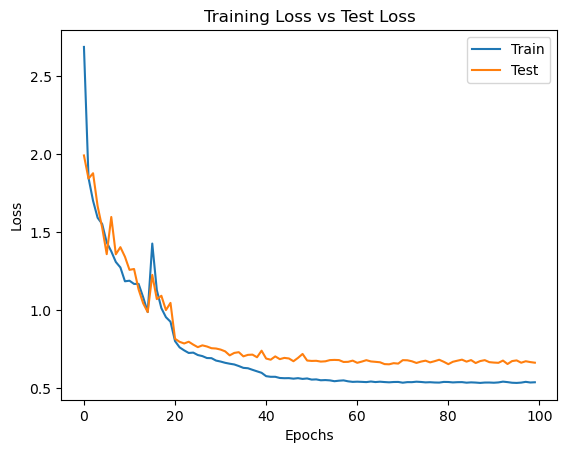

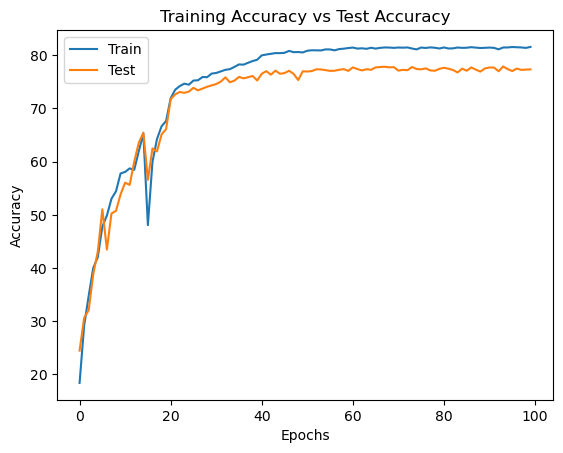

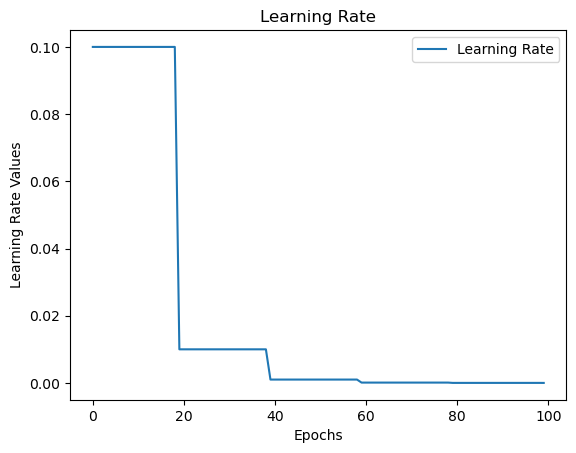

In [21]:
#Plot Results
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses.value_list)
plt.plot(test_losses.value_list)
plt.title('Training Loss vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.figure()
plt.plot(train_accuracy_top1.value_list)
plt.plot(test_accuracy_top1.value_list)
plt.title('Training Accuracy vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()


plt.figure()
plt.plot(learning_rate_values.value_list)
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate Values')
plt.legend(['Learning Rate'])
plt.show()

In [22]:
import pickle
import os
info={
    'Train Loss':train_losses,
    'Test Loss':test_losses,
    'acc_train':train_accuracy_top1,
    'acc_test':test_accuracy_top1,
    'acc_train_5':train_accuracy_top5,
    'acc_test_5':test_accuracy_top5,
    'Learning Rate':learning_rate_values,
}

final_results={
    'train_results':train_results,
    'test_results':test_results,
    'model_info':info
}


file_name = f'./Results_{args.modelName}_{args.dataset}_score.pickle'
with open(file_name, 'wb') as handle:
    pickle.dump(final_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Final results are stored")

Final results are stored
